In [1]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from hyperopt import hp, fmin, tpe, Trials
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from scipy.stats import normaltest
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
from tqdm import tqdm
tqdm.pandas()
import plotly.io as pio
from IPython.core.display import display, HTML 

C:\Users\Павел\AppData\Local\Temp\ipykernel_11956\960289494.py:35: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# **EDA**

In [2]:
# чтение файла
df = pd.read_csv('df.csv', sep=',')
# вывод первых строк
df.head(3)

,Unnamed: 0,status,propertyType,baths,city,sqft,zipcode,beds,state,target,...,Year built,Remodeled year,Price/sqft,Number of schools,Min rating,Max rating,Mean rating,Min distance,Max distance,Mean distance
0,0,active,single family,3.5,southern pines,2900.000,28387,4.0,NC,418.000,...,3.0,NaN,144.0,8.0,4.0,7.0,5.200000,2.70,12.60,5.537500
1,1,for sale,single family,3.0,other,1.947,99216,3.0,WA,310.000,...,3.0,NaN,159.0,3.0,4.0,10.0,6.000000,1.01,1.65,1.326667
2,2,for sale,single family,2.0,los angeles,3.000,90049,3.0,CA,2.895,...,61.0,55.0,965.0,3.0,4.0,8.0,6.666667,1.19,2.63,1.960000


In [3]:
#размерность таблицы
df.shape

(377185, 25)

In [4]:
# процент пропусков
percent_null = (df.isnull().sum() / len(df)) * 100
display(percent_null.sort_values(ascending=False))

Remodeled year       59.946711
beds                 29.975476
baths                28.608508
lotsize              25.413259
Price/sqft           17.481342
Year built           16.860692
sqft                 10.975251
Mean rating           1.357689
Max rating            1.357689
Min rating            1.357689
Max distance          1.135782
Min distance          1.135782
Mean distance         1.135782
target                0.657767
Parking               0.000000
Heating               0.000000
status                0.000000
Cooling               0.000000
Private_pool          0.000000
Number of schools     0.000000
state                 0.000000
zipcode               0.000000
city                  0.000000
propertyType          0.000000
Unnamed: 0            0.000000
dtype: float64

В признаке Remodeled year почти 60% пропусков. Удалим его.

In [5]:
df = df.drop('Remodeled year', axis=1)

In [6]:
df = df.drop('Unnamed: 0', axis=1)

Удалим строки с пропущенными значениями в признаке 'target'

In [7]:
df = df[df['target'].notna()]

Заполним пропущенные значения в других признаках

In [8]:
values = {
    'beds': int(df['beds'].median()),
    'baths': int(df['baths'].median()),
    'lotsize': df['lotsize'].median(),
    'Price/sqft': df['Price/sqft'].median(),
    'Year built': df['Year built'].median(),
    'sqft': df['sqft'].median(),
    'Min rating': df['Min rating'].median(),
    'Max rating': df['Max rating'].median(),
    'Mean rating': df['Mean rating'].median(),
    'Min distance': df['Min distance'].median(),
    'Max distance': df['Max distance'].median(),
    'Mean distance': df['Mean distance'].median(),
}

df = df.fillna(values)

df.isnull().mean()

status               0.0
propertyType         0.0
baths                0.0
city                 0.0
sqft                 0.0
zipcode              0.0
beds                 0.0
state                0.0
target               0.0
Private_pool         0.0
Cooling              0.0
lotsize              0.0
Parking              0.0
Heating              0.0
Year built           0.0
Price/sqft           0.0
Number of schools    0.0
Min rating           0.0
Max rating           0.0
Mean rating          0.0
Min distance         0.0
Max distance         0.0
Mean distance        0.0
dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374704 entries, 0 to 377184
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             374704 non-null  object 
 1   propertyType       374704 non-null  object 
 2   baths              374704 non-null  float64
 3   city               374704 non-null  object 
 4   sqft               374704 non-null  float64
 5   zipcode            374704 non-null  object 
 6   beds               374704 non-null  float64
 7   state              374704 non-null  object 
 8   target             374704 non-null  float64
 9   Private_pool       374704 non-null  int64  
 10  Cooling            374704 non-null  object 
 11  lotsize            374704 non-null  float64
 12  Parking            374704 non-null  object 
 13  Heating            374704 non-null  object 
 14  Year built         374704 non-null  float64
 15  Price/sqft         374704 non-null  float64
 16  Number 

In [10]:
# Составим список категориальных признаков:
categorial_features = ['status','propertyType','city','zipcode','state','Cooling', 'Parking', 'Heating', 'Private_pool']
 
# Составим список числовых признаков:
number_features = ['baths', 'sqft', 'beds', 'target', 'lotsize', 'Year built', 'Price/sqft', 
                   'Number of schools', 'Min rating', 'Max rating', 'Mean rating', 'Min distance', 'Max distance', 'Mean distance']

Работа с дубликатами

In [11]:
# Найдем дубликаты:

mask = df.duplicated(subset=df.columns) 
data_duplicates = df[mask] 
print(data_duplicates.shape[0])

2645


In [12]:
# Удалим дубликаты

df.drop_duplicates(inplace=True)

Работа с выбросами

Посмотрим, как распределены числовые признаки

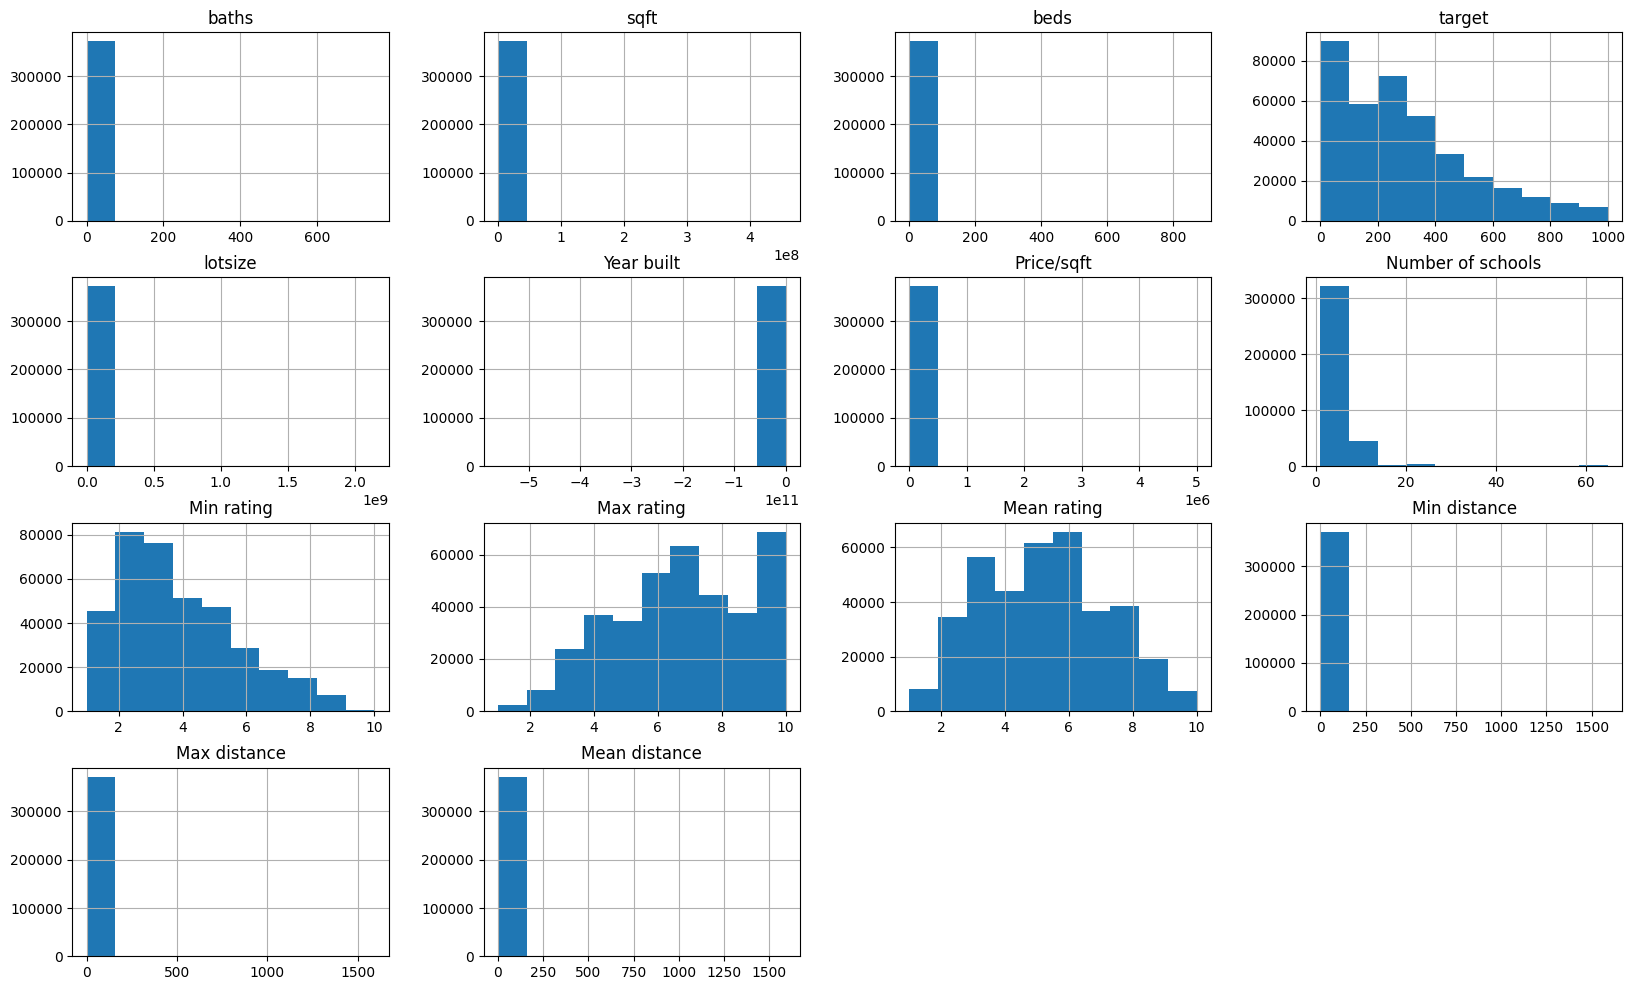

In [13]:
df[number_features].hist(figsize=(20, 12))
pass

Большинство признаков не имеют нормального распределения

Посмотрим на выбросы

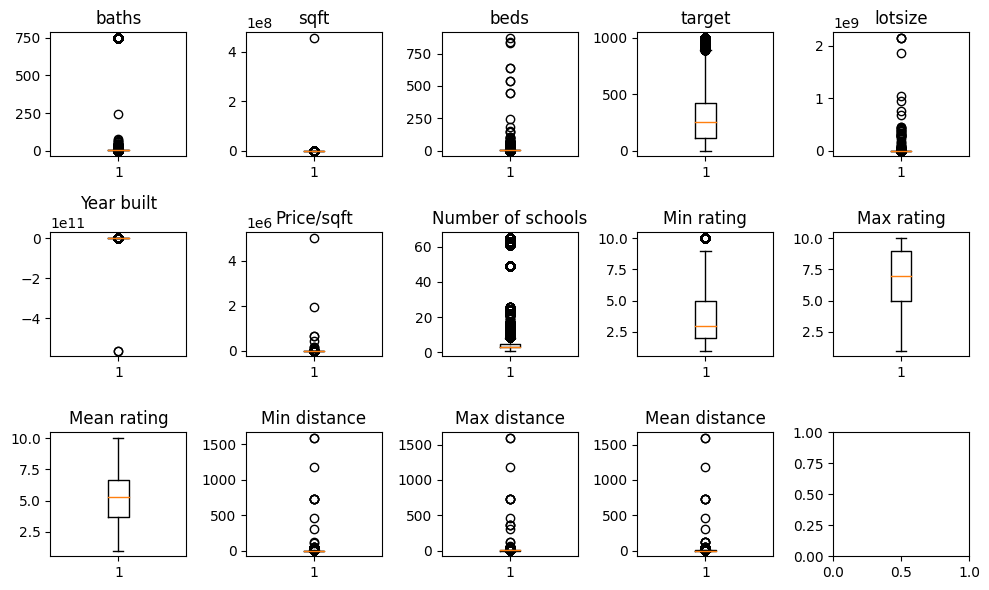

In [14]:

def plot_outliers(df, features):
    num_plots = len(features)
    num_cols = 5  
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.5)

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].boxplot(df[feature])
        axs[row, col].set_title(feature)

    plt.tight_layout()
    plt.show()

plot_outliers(df, number_features)

Во всех признаках, за исключением Max rating и Mean rating, имеются выбросы. Обработаем их с помощью метода трех сигм.

In [ ]:
# Используем функцию для удаления выбросов на основе метода трех сигм

In [15]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return cleaned

In [16]:
number_features_to_clean = ['baths', 'sqft', 'beds', 'target', 'lotsize', 'Year built', 'Price/sqft', 
                   'Number of schools', 'Min rating', 'Max rating', 'Mean rating', 'Min distance', 'Max distance', 'Mean distance']

first_cleaned_data = df.copy()
for feature in number_features_to_clean:
    first_cleaned_data = outliers_z_score_mod(first_cleaned_data, feature, False, 3, 5)
    print(first_cleaned_data.shape)

(371821, 23)
(371820, 23)
(371629, 23)
(371629, 23)
(371576, 23)
(371574, 23)
(371566, 23)
(370040, 23)
(370040, 23)
(370040, 23)
(370040, 23)
(369826, 23)
(369693, 23)
(368993, 23)


Посмотрим на распределение признаков и выбросы

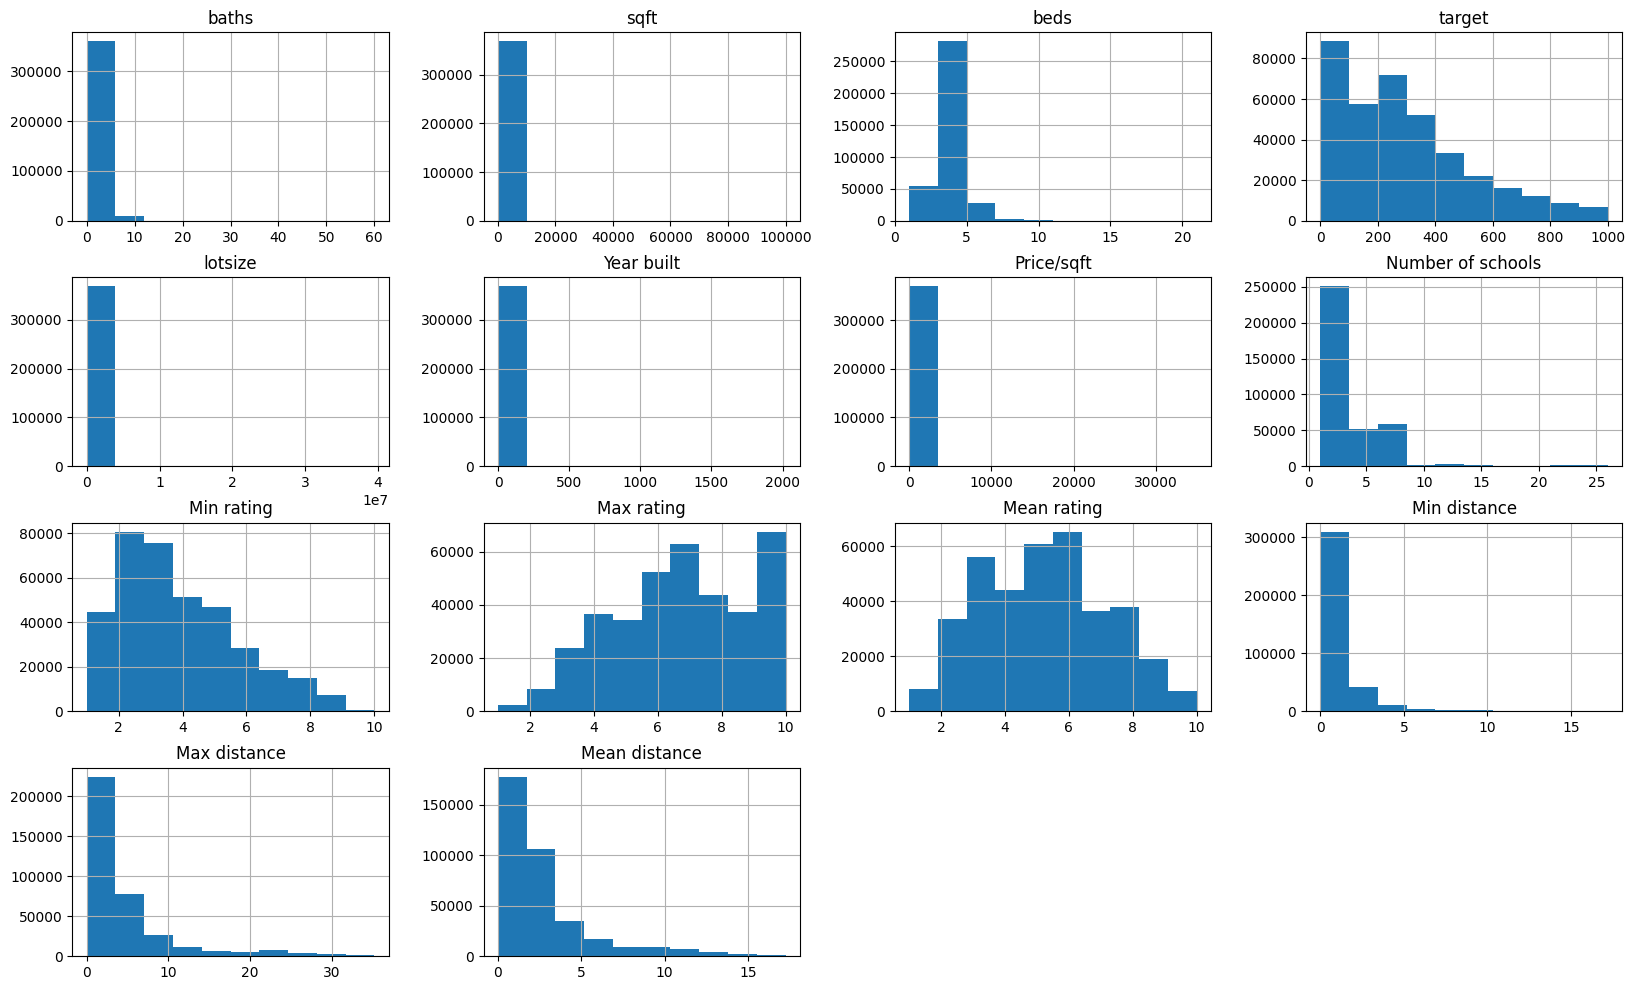

In [17]:
first_cleaned_data[number_features_to_clean].hist(figsize=(20, 12))
pass

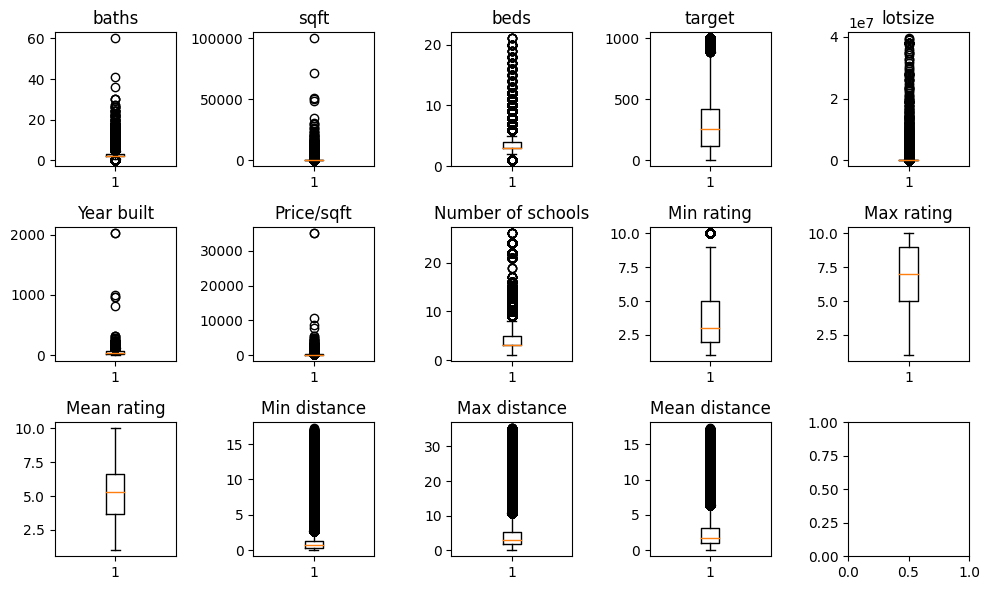

In [18]:
def plot_outliers(first_cleaned_data, features):
    num_plots = len(features)
    num_cols = 5  
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.5)

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].boxplot(first_cleaned_data[feature])
        axs[row, col].set_title(feature)

    plt.tight_layout()
    plt.show()

plot_outliers(first_cleaned_data, number_features_to_clean)

Размер выбросов уменьшился (например, в признаке baths максимальный выброс был в значении 750, а после обработки методом трех сигм максимальный выброс находится в значении 60), но распределения все еще далеки от нормальных. Т.е. в дальнейшем признаки необходимо будет стандартизировать и логарифмировать.

In [19]:
first_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368993 entries, 0 to 377184
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             368993 non-null  object 
 1   propertyType       368993 non-null  object 
 2   baths              368993 non-null  float64
 3   city               368993 non-null  object 
 4   sqft               368993 non-null  float64
 5   zipcode            368993 non-null  object 
 6   beds               368993 non-null  float64
 7   state              368993 non-null  object 
 8   target             368993 non-null  float64
 9   Private_pool       368993 non-null  int64  
 10  Cooling            368993 non-null  object 
 11  lotsize            368993 non-null  float64
 12  Parking            368993 non-null  object 
 13  Heating            368993 non-null  object 
 14  Year built         368993 non-null  float64
 15  Price/sqft         368993 non-null  float64
 16  Number 

Построим матрицу корреляций

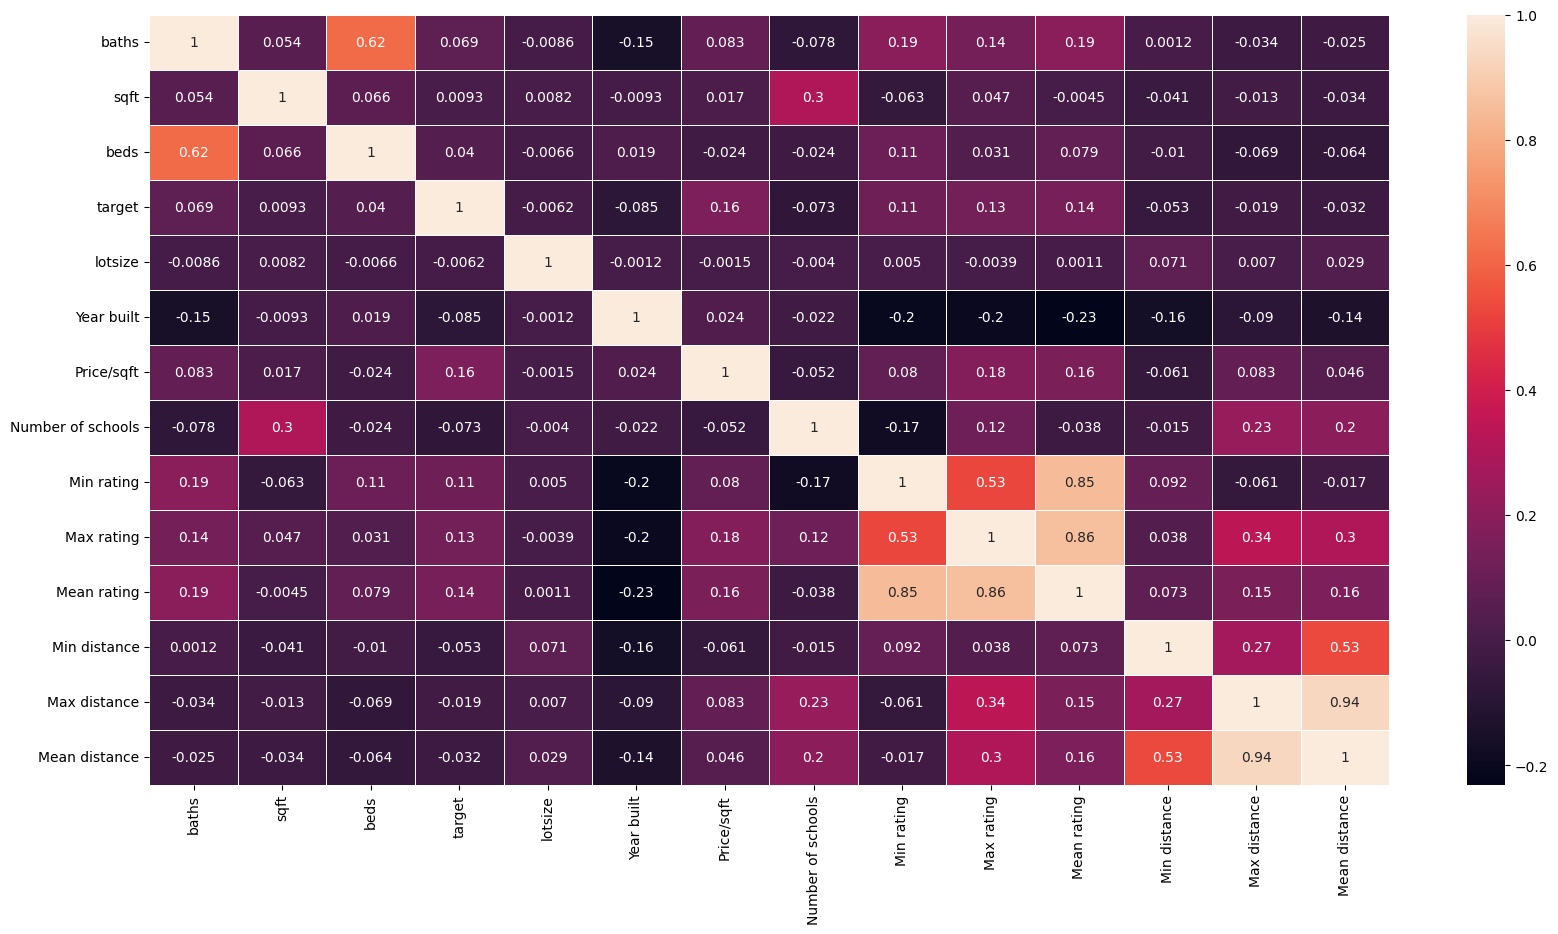

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(first_cleaned_data[number_features_to_clean].corr(), annot=True, linewidths=.5, ax=ax)
pass

Сильно скоррелированными являются пары признаков: Min rating и Mean rating, Max rating и Mean rating, Max distance и Mean distance. Также достаточно высокий коэффициент корреляции наблюдается между признаками beds и baths, и хотя он менее 0,7, результаты исследования (не отражены здесь) показывают, что метрики чуть лучше при удалении одного из этих признаков.

In [21]:
first_cleaned_data = first_cleaned_data.drop(['Max distance', 'Min rating', 'Max rating', 'baths'], axis = 1)

Прологарифмируем числовые признаки

In [22]:
number_features_to_log = ['sqft', 'beds', 'lotsize', 'Year built', 'Price/sqft', 
                   'Number of schools', 'Mean rating', 'Min distance', 'Mean distance']

for feature in number_features_to_log:
    first_cleaned_data[feature] = first_cleaned_data[feature].progress_apply(lambda x: np.log(x+1) if x >= 0 else 0)

100%|██████████| 368993/368993 [00:01<00:00, 339434.70it/s]


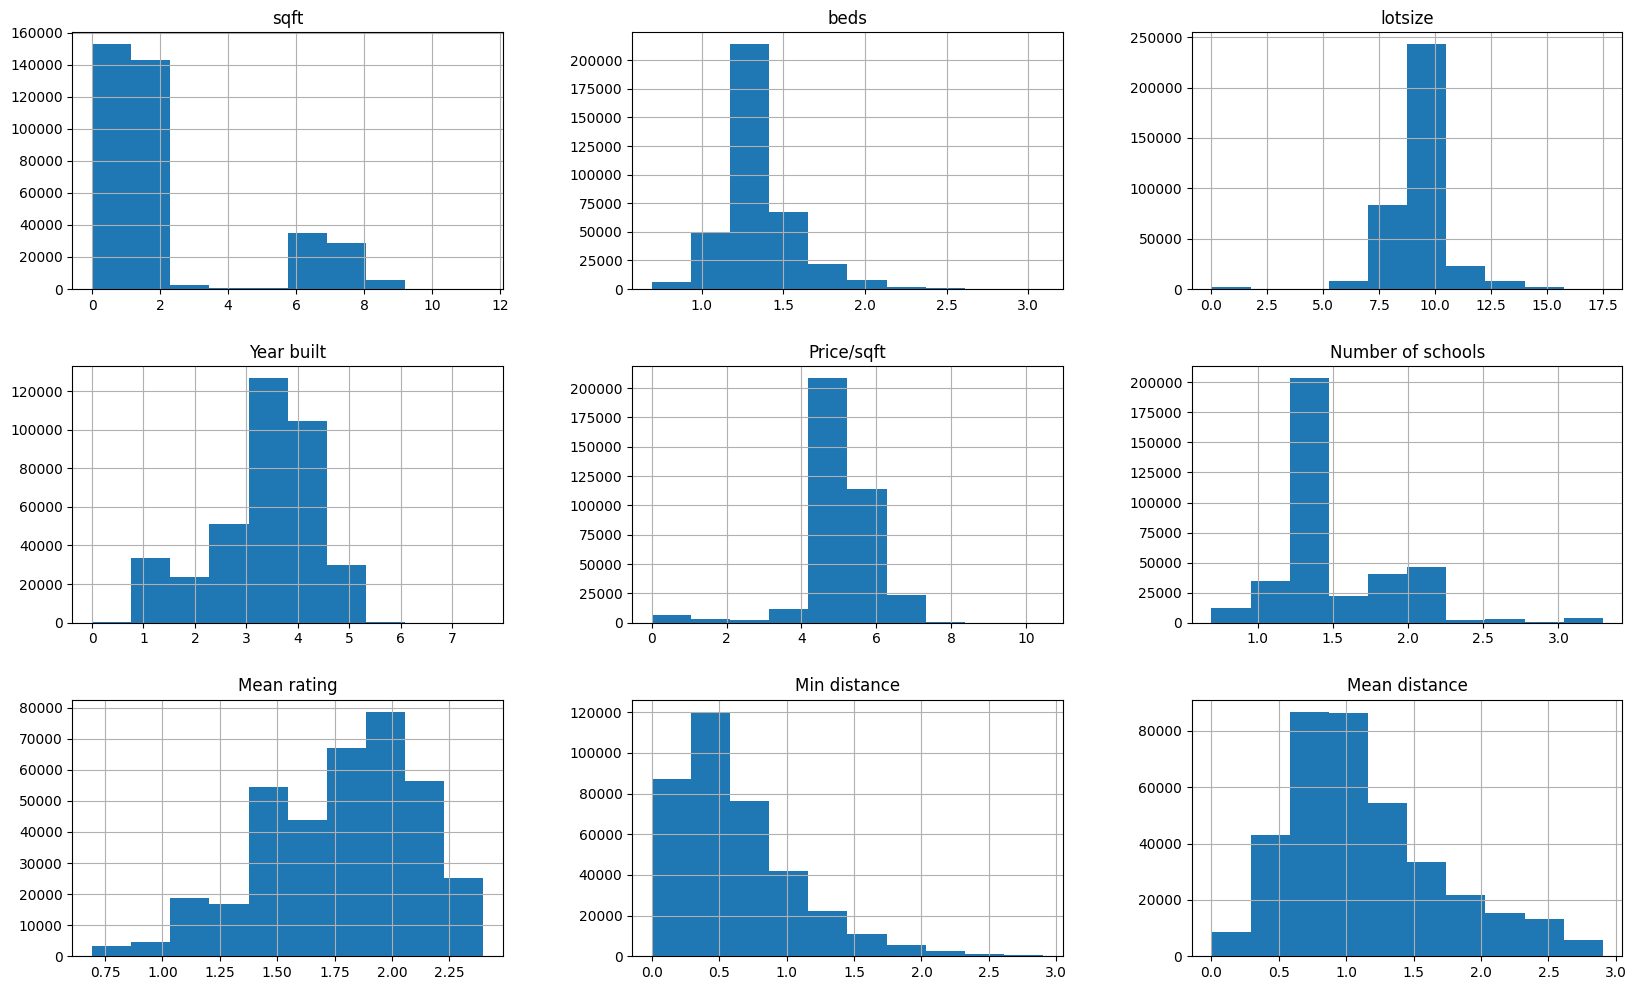

In [23]:
first_cleaned_data[number_features_to_log].hist(figsize=(20, 12))
pass

Закодируем категориальные признаки. Используем для этого Label Encoder

In [24]:
categorial_features = ['status','propertyType','city','zipcode','state','Cooling', 'Parking', 'Heating']
for feature in categorial_features:
    first_cleaned_data[feature] = LabelEncoder().fit_transform(first_cleaned_data[feature])
    first_cleaned_data[feature] = first_cleaned_data[feature].astype("category")

Подготовим данные для дальнейшего анализа и моделирования

In [25]:
X = first_cleaned_data.drop('target', axis=1)
y = first_cleaned_data['target'].apply(lambda x: np.log(x+1))

Проведем оценку важности признаков

<AxesSubplot: >

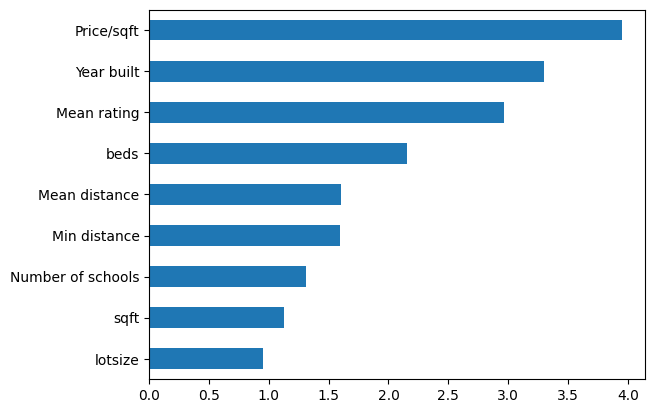

In [26]:
number_features_to_scale = ['sqft', 'beds', 'lotsize', 'Year built', 'Price/sqft', 
                   'Number of schools', 'Mean rating', 'Min distance', 'Mean distance']
# Для оценки значимости количественных переменных будем использовать функцию f_classif из библиотеки sklearn
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[number_features_to_scale], y)[0], index = number_features_to_scale)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [27]:
categorial_features=['status','propertyType','city','zipcode','state','Cooling', 'Parking', 'Heating', 'Private_pool']

<AxesSubplot: >

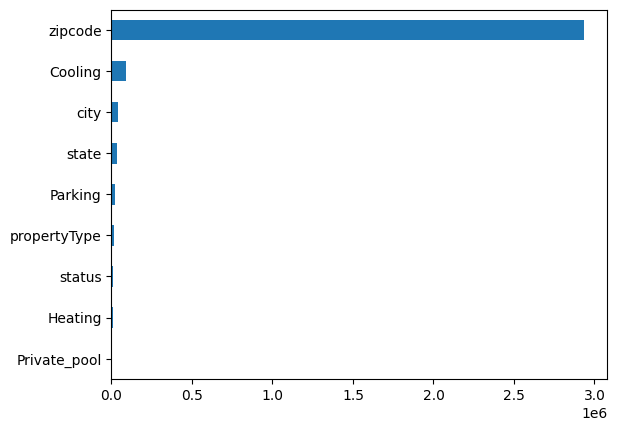

In [28]:
# Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат
y_int=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[categorial_features], y_int)[0], index=categorial_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [29]:
# Удалим наименее значимый признак Private_pool
first_cleaned_data.drop(['Private_pool'], 
    axis=1, inplace=True)

In [30]:
categorial_features = ['status','propertyType','city','zipcode','state','Cooling', 'Parking', 'Heating']

Уточним нет ли коррелированных пар в категориальных признаках

In [31]:
# Уточним коррелированные пары
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


print('Коррелированные пары:')
get_correlated(first_cleaned_data.corr(method='spearman'))

Коррелированные пары:


Series([], dtype: object)

Коррелированных пар нет. Можно приступать к моделированию. 
Разделим выборку на обучающую и тестовую.

In [32]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

Стандартизируем числовые данные перед подачей в модель.

In [33]:
number_features_to_scale = ['sqft', 
                            'beds', 
                            'lotsize', 
                            'Year built', 
                            'Price/sqft', 
                            'Number of schools', 
                            'Mean rating', 
                            'Min distance', 
                            'Mean distance'
                            ]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[number_features_to_scale])
X_train_scaled = pd.DataFrame(scaler.transform(X_train[number_features_to_scale]), columns=number_features_to_scale)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid[number_features_to_scale]), columns=number_features_to_scale)

In [34]:
X_train_scaled = pd.concat([X_train_scaled, X_train[categorial_features].reset_index(drop=True)], axis = 1)
X_valid_scaled = pd.concat([X_valid_scaled, X_valid[categorial_features].reset_index(drop=True)], axis = 1)

# **ML**

## LinearRegression

In [35]:
lr= linear_model.LinearRegression()
#Обучение модели
lr.fit(X_train_scaled,  y_train)
y_train_predict = lr.predict(X_train_scaled)
y_valid_predict = lr.predict(X_valid_scaled)
#Mетрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)
#Вывод результатов
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('MAPE score: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train,y_train_predict) * 100))
print('MAPE score: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_valid,y_valid_predict) * 100))

Train MSE: 2.61
Test MSE: 2.62
Train MAE: 1.18
Test MAE: 1.18
Train R2: 0.07
Test R2: 0.07
MAPE score: 59.11 %
MAPE score: 59.40 %


Значения MSE, MAE, MAPE и R^2, как для обучающей, так и для тестовой выборок, практически одинаковы, т.е. недообучения и переобучения модели не наблюдается.

Значения R^2 0,07 говорит о том, что модель объясняет лишь небольшую часть (7%) дисперсии целевой переменной. Предсказательная способность в этом случае достаточно низкая.

Значения MAPE по обучению и тестированию высоки, что указывает на то, что прогнозы модели имеют очень большое процентное отличие от фактических значений. 

Основываясь на этих результатах, можно сделать вывод, что модель работает недостаточно хорошо. 

## PolynomialFeatures

In [36]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=True)
poly.fit(X_train_scaled)
#Создадим полиномиальные признаки для  обучающей выборки
X_train_poly = poly.transform(X_train_scaled)
#Создадим полиномиальные признаки для тестовой выборки
X_valid_poly = poly.transform(X_valid_scaled)

lr_model_poly = linear_model.LinearRegression()
#Обучение модели
lr_model_poly.fit(X_train_poly, y_train)
#Создание прогноза для обучающей выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Создание прогноза для тестовой выборки
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
#Метрики
mse_train = mean_squared_error(y_train, y_train_predict_poly)
mse_test = mean_squared_error(y_valid, y_valid_predict_poly)
mae_train = mean_absolute_error(y_train, y_train_predict_poly)
mae_test = mean_absolute_error(y_valid, y_valid_predict_poly)
r2_train = r2_score(y_train, y_train_predict_poly)
r2_test = r2_score(y_valid, y_valid_predict_poly)
# Вывод результата
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")                  
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict_poly)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict_poly)), '%')

Train MSE: 2.02
Test MSE: 2.02
Train MAE: 1.02
Test MAE: 1.02
Train R2: 0.28
Test R2: 0.28
Train MAPE score: 47.39 %
Test MAPE score: 47.73 %


Результаты несколько улучшились, но модель все еще работает недостаточно хорошо.

## Ridge

In [37]:
ridge_lr_poly = linear_model.Ridge(alpha=1, solver = 'cholesky'
                                  # positive = True
                                  )
#Обучение модели
ridge_lr_poly.fit(X_train_scaled, y_train)
#Создание прогноза для обучающей выборки
y_train_predict = ridge_lr_poly.predict(X_train_scaled)
#Создание прогноза для тестовой выборки
y_valid_predict = ridge_lr_poly.predict(X_valid_scaled)
# Метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)
#Вывод результатов
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}") 
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 2.61
Test MSE: 2.62
Train MAE: 1.18
Test MAE: 1.18
Train R2: 0.07
Test R2: 0.07
Train MAPE score: 59.11 %
Test MAPE score: 59.40 %


Результаты хуже, чем при полиномиальной регрессии

# Lasso

In [38]:
clf = linear_model.Lasso(alpha=0.05)
clf.fit(X_train_scaled, y_train)
#Прогноз для обучающей выборки
y_train_predict = clf.predict(X_train_scaled)
#Прогноз для тестовой выборки
y_valid_predict = clf.predict(X_valid_scaled)
#Метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)
#Вывод результатов
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 2.73
Test MSE: 2.74
Train MAE: 1.22
Test MAE: 1.22
Train R2: 0.03
Test R2: 0.03
Train MAPE score: 60.95 %
Test MAPE score: 61.33 %


Результаты неудовлетворительные

# DecisionTreeRegressor

In [39]:
regr = DecisionTreeRegressor()
#Обучение модели 
regr.fit(X_train_scaled,  y_train)
y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
#Метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)
#Вывод результатов
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 0.04
Test MSE: 0.60
Train MAE: 0.02
Test MAE: 0.19
Train R2: 0.99
Test R2: 0.79
Train MAPE score: 0.82 %
Test MAPE score: 8.66 %


Mодель показывает хорошие результаты на обучающей выборке, с низкими значениями MSE, MAE и высоким значением R2. Однако на тестовой выборке модель менее точна (с более высокими значениями MSE, MAE и более низким значением R2). Это может указывать на переобучение модели на обучающих данных и неспособность обобщать на новые данные.

Оптимизируем параметры

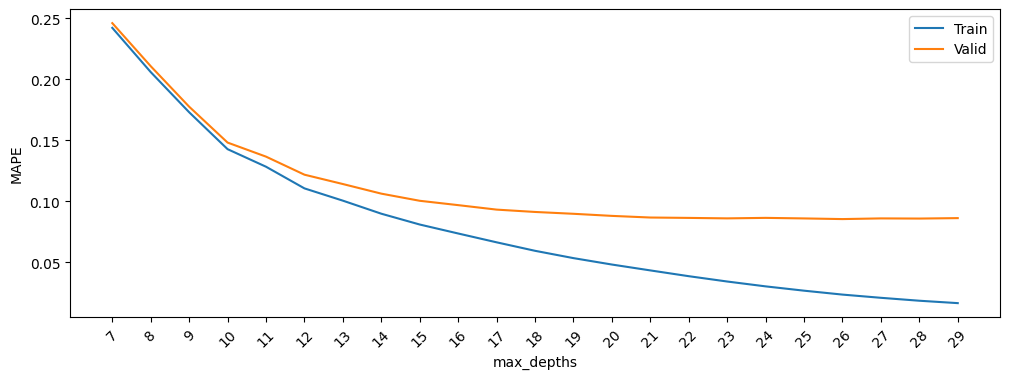

In [41]:
max_depths = range(7, 30)
#Создание пустых списков, в которые мы будем добавлять результаты
train_scores = []
valid_scores = []
for depth in max_depths:
    #Создание объекта класса линейной регрессии с регуляризацией L1
    regr = DecisionTreeRegressor(max_depth = depth)
    #Обучение модели
    regr.fit(X_train_scaled,  y_train)
    #Предсказание для обучающей выборки
    y_train_predict = regr.predict(X_train_scaled)
    #Предсказание для тестовой выборки
    y_valid_predict = regr.predict(X_valid_scaled)
    #Вычисление коэффициентов детерминации для двух проб и добавление их в списки
    train_scores.append(metrics.mean_absolute_percentage_error(y_train,y_train_predict))
    valid_scores.append(metrics.mean_absolute_percentage_error(y_valid,y_valid_predict))
    
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(max_depths, train_scores, label='Train') 
ax.plot(max_depths, valid_scores, label='Valid') 
ax.set_xlabel('max_depths') 
ax.set_ylabel('MAPE') 
ax.set_xticks(max_depths) 
ax.xaxis.set_tick_params(rotation=45) 
ax.legend(); 

Выполним подбор гиперпараметров с перекрестной проверкой

In [46]:
space={
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'max_depth' : hp.quniform('max_depth', 6, 30, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 20, 1)
      }

random_state =42
def hyperopt_dt(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):

    params = {
            'min_samples_split': int(params['min_samples_split']), 
            'max_depth': int(params['max_depth']), 
            'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    model = DecisionTreeRegressor(**params, random_state=random_state)
 
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1).mean()

    return -score
 
trials = Trials()
best=fmin(hyperopt_dt, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=50, 
          trials=trials, 
          show_progressbar=True,
          rstate=np.random.default_rng(random_state)
         )

print("Best hyperparameter values {}".format(best))

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [09:40<00:00, 11.60s/trial, best loss: 0.09073019969323184]
Best hyperparameter values {'max_depth': 26.0, 'min_samples_leaf': 3.0, 'min_samples_split': 8.0}


In [49]:
%%time
regr = DecisionTreeRegressor(max_depth = 26, min_samples_leaf = 3, min_samples_split = 8)

regr.fit(X_train_scaled,  y_train)
y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 0.17
Test MSE: 0.48
Train MAE: 0.11
Test MAE: 0.19
Train R2: 0.94
Test R2: 0.83
Train MAPE score: 4.79 %
Test MAPE score: 8.58 %
CPU times: total: 5.19 s
Wall time: 5.26 s


Разница между обучением и предсказанием несколько сократилась

# RandomForestRegressor

In [40]:
random_state=42
# Создаем экземпляр модели RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=random_state)

# Обучаем модель на обучающих данных
rf_regressor.fit(X_train_scaled, y_train)

# Предсказания на обучающих и тестовых данных
y_train_predict = rf_regressor.predict(X_train_scaled)
y_valid_predict = rf_regressor.predict(X_valid_scaled)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 0.08
Test MSE: 0.34
Train MAE: 0.07
Test MAE: 0.16
Train R2: 0.97
Test R2: 0.88
Train MAPE score: 3.50 %
Test MAPE score: 8.16 %


Неплохие результаты

# ElasticNetCV

In [52]:
from sklearn.model_selection import KFold
random_state=42
# Создаем и тренируем модель ElasticNetCV с кросс-валидацией по 5 фолдам
model_el = ElasticNetCV(cv=5, random_state=random_state)
model_el.fit(X_train_scaled, y_train)
# Предсказания для обучающей и тестовой выборок
y_train_pred = model_el.predict(X_train_scaled)
y_valid_pred = model_el.predict(X_valid_scaled)
# Метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_valid, y_valid_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_valid, y_valid_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_valid, y_valid_pred)
# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 2.73
Test MSE: 2.75
Train MAE: 1.22
Test MAE: 1.22
Train R2: 0.03
Test R2: 0.03
Train MAPE score: 4.79 %
Test MAPE score: 8.58 %


Очень плохой показатель R2

# GradientBoostingRegressor

In [53]:
%%time
gb = GradientBoostingRegressor(
    max_depth=10, 
    learning_rate=0.5,
    n_estimators=300, 
    random_state=42 
)
gb.fit(X_train_scaled,  y_train)
y_train_predict = gb.predict(X_train_scaled)
y_valid_predict = gb.predict(X_valid_scaled)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_valid, y_valid_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_valid, y_valid_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_valid, y_valid_pred)
# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

Train MSE: 2.73
Test MSE: 2.75
Train MAE: 1.22
Test MAE: 1.22
Train R2: 0.03
Test R2: 0.03
Train MAPE score: 2.94 %
Test MAPE score: 10.82 %
CPU times: total: 14min 37s
Wall time: 14min 41s


Очень плохой показатель R2

# StackingRegressor

In [58]:
%%time
estimators = [
    ('dt', DecisionTreeRegressor(max_depth = 28, min_samples_leaf = 2, min_samples_split = 4)),
    ('rf', RandomForestRegressor (max_depth=20, n_estimators=100, random_state=42))
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator = CatBoostRegressor(iterations=100,
                          l2_leaf_reg = 2.75,
                          learning_rate=0.75,
                          depth=10
                          cat_features = categorial_features
                         ),
    verbose = 2
)


model.fit(X_train_scaled,  y_train)
y_train_predict = model.predict(X_train_scaled)
y_valid_predict = model.predict(X_valid_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_valid, y_valid_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_valid, y_valid_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_valid, y_valid_pred)
# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.9min finished


0:	learn: 0.7362137	total: 208ms	remaining: 20.6s
1:	learn: 0.6159608	total: 268ms	remaining: 13.1s
2:	learn: 0.6025112	total: 333ms	remaining: 10.8s
3:	learn: 0.5994752	total: 394ms	remaining: 9.45s
4:	learn: 0.5964297	total: 461ms	remaining: 8.76s
5:	learn: 0.5950496	total: 534ms	remaining: 8.37s
6:	learn: 0.5942665	total: 612ms	remaining: 8.13s
7:	learn: 0.5933102	total: 682ms	remaining: 7.84s
8:	learn: 0.5922153	total: 761ms	remaining: 7.7s
9:	learn: 0.5916812	total: 836ms	remaining: 7.52s
10:	learn: 0.5913568	total: 913ms	remaining: 7.39s
11:	learn: 0.5907620	total: 1.01s	remaining: 7.44s
12:	learn: 0.5902660	total: 1.09s	remaining: 7.33s
13:	learn: 0.5898853	total: 1.18s	remaining: 7.22s
14:	learn: 0.5893459	total: 1.25s	remaining: 7.1s
15:	learn: 0.5891202	total: 1.33s	remaining: 6.99s
16:	learn: 0.5884530	total: 1.4s	remaining: 6.85s
17:	learn: 0.5880466	total: 1.49s	remaining: 6.79s
18:	learn: 0.5876775	total: 1.57s	remaining: 6.68s
19:	learn: 0.5869098	total: 1.64s	remaining:

Все метрики:
Train MSE: 2.73
Test MSE: 2.75
Train MAE: 1.22
Test MAE: 1.22
Train R2: 0.03
Test R2: 0.03
Train MAPE score: 5.32 %
Test MAPE score: 8.39 %

Плохой показатель R2

# HuberRegressor

In [59]:
from sklearn.linear_model import HuberRegressor

# Создание экземпляра модели Robust Regression
model = HuberRegressor()

# Обучение модели
model.fit(X_train_scaled, y_train)

# Прогнозирование  
y_train_predict = model.predict(X_train_scaled)
y_valid_predict = model.predict(X_valid_scaled)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')



Train MSE: 3.10
Test MSE: 3.12
Train MAE: 1.17
Test MAE: 1.17
Train R2: -0.11
Test R2: -0.11
Train MAPE score: 65.18 %
Test MAPE score: 65.58 %


Неудовлетворительные результаты

# CatBoostRegressor

In [60]:
%%time
categorial_features = ['status','propertyType','city','zipcode','state','Cooling', 'Parking', 'Heating']

model = CatBoostRegressor(iterations=1000,
                          #l2_leaf_reg = 2.75,
                          learning_rate=0.55,
                          depth=10,
                          
                          cat_features = categorial_features
                         )
model.fit(X_train_scaled,  y_train)
y_train_predict = model.predict(X_train_scaled)
y_valid_predict = model.predict(X_valid_scaled)
# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)
# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')

0:	learn: 1.2570041	total: 715ms	remaining: 11m 54s
1:	learn: 1.0956548	total: 1.49s	remaining: 12m 24s
2:	learn: 1.0066699	total: 2.32s	remaining: 12m 51s
3:	learn: 0.9570308	total: 3.07s	remaining: 12m 43s
4:	learn: 0.9402219	total: 3.87s	remaining: 12m 50s
5:	learn: 0.9042709	total: 4.61s	remaining: 12m 43s
6:	learn: 0.8787285	total: 5.32s	remaining: 12m 34s
7:	learn: 0.8718042	total: 6.19s	remaining: 12m 47s
8:	learn: 0.8582661	total: 6.89s	remaining: 12m 38s
9:	learn: 0.8456789	total: 7.6s	remaining: 12m 32s
10:	learn: 0.8356330	total: 8.24s	remaining: 12m 21s
11:	learn: 0.8277486	total: 8.94s	remaining: 12m 16s
12:	learn: 0.8239056	total: 9.75s	remaining: 12m 20s
13:	learn: 0.8167153	total: 10.4s	remaining: 12m 14s
14:	learn: 0.8084776	total: 11s	remaining: 12m 5s
15:	learn: 0.8062114	total: 11.9s	remaining: 12m 10s
16:	learn: 0.8028774	total: 12.8s	remaining: 12m 17s
17:	learn: 0.7984437	total: 13.4s	remaining: 12m 13s
18:	learn: 0.7956764	total: 14.2s	remaining: 12m 11s
19:	lea

Все метрики:
Train MSE: 0.25
Test MSE: 0.40
Train MAE: 0.23
Test MAE: 0.28
Train R2: 0.91
Test R2: 0.86
Train MAPE score: 9.88 %
Test MAPE score: 12.46 %

Неплохой результат

# Support Vector Regression

In [62]:
from sklearn.svm import SVR

# Создание экземпляра модели Support Vector Machines
model_svm = SVR()

# Обучение модели Support Vector Machines
model_svm.fit(X_train_scaled, y_train)

# Прогнозирование на тестовом наборе данных с помощью модели Support Vector Machines
y_train_predict = model_svm.predict(X_train_scaled)
y_valid_predict = model_svm.predict(X_valid_scaled)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_predict)
mse_test = mean_squared_error(y_valid, y_valid_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mae_test = mean_absolute_error(y_valid, y_valid_predict)
r2_train = r2_score(y_train, y_train_predict)
r2_test = r2_score(y_valid, y_valid_predict)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")
print('Train MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_train,y_train_predict)), '%')
print('Test MAPE score: {:.2f}'.format(100*metrics.mean_absolute_percentage_error(y_valid,y_valid_predict)), '%')



Train MSE: 3.03
Test MSE: 3.06
Train MAE: 1.09
Test MAE: 1.10
Train R2: -0.08
Test R2: -0.09
Train MAPE score: 65.79 %
Test MAPE score: 66.21 %


Неудовлетворительные результаты

Создадим датафрейм со всеми моделями и метриками

In [3]:
data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2', 'Train MAPE', 'Test MAPE'],
        'LinearRegression': [2.61, 2.62, 1.18, 1.18, 0.07, 0.07, 59.11, 59.40],
        'PolynomialFeatures': [2.02, 2.02, 1.02, 1.02, 0.28, 0.28, 47.39, 47.73],
        'Ridge': [2.61, 2.62, 1.18, 1.18, 0.07, 0.07, 59.11, 59.40],
        'Lasso': [2.73, 2.74, 1.22, 1.22, 0.03, 0.03, 60.95, 61.33],
        'DecisionTreeRegressor': [0.04, 0.06, 0.02, 0.19, 0.99, 0.79, 0.82, 8.66],
        'DecisionTreeRegressor_optimisation': [0.17, 0.48, 0.11, 0.19, 0.94, 0.83, 4.79, 8.58],
        'RandomForestRegressor': [0.08, 0.34, 0.07, 0.16, 0.97, 0.88, 3.50, 8.16],
        'ElasticNetCV': [2.73, 2.75, 1.22, 1.22, 0.03, 0.03, 4.79, 8.58],
        'GradientBoostingRegressor': [2.73, 2.75, 1.22, 1.22, 0.03, 0.03, 2.94, 10.82],
        'StackingRegressor': [2.73, 2.75, 1.22, 1.22, 0.03, 0.03, 5.32, 8.39],
        'HuberRegressor': [3.10, 3.12, 1.17, 1.17, -0.11, -0.11, 65.18, 65.58],
        'CatBoostRegressor':[0.25, 0.4, 0.23, 0.28, 0.91, 0.86, 9.88, 12.46],
        'SupportVectorRegressor':[3.03, 3.06, 1.09, 1.10, -0.08, -0.09, 65.79, 66.21]}

df_metric = pd.DataFrame(data)
df_metric.head(8)

,Metric,LinearRegression,PolynomialFeatures,Ridge,Lasso,DecisionTreeRegressor,DecisionTreeRegressor_optimisation,RandomForestRegressor,ElasticNetCV,GradientBoostingRegressor,StackingRegressor,HuberRegressor,CatBoostRegressor,SupportVectorRegressor
0,Train MSE,2.61,2.02,2.61,2.73,0.04,0.17,0.08,2.73,2.73,2.73,3.10,0.25,3.03
1,Test MSE,2.62,2.02,2.62,2.74,0.06,0.48,0.34,2.75,2.75,2.75,3.12,0.40,3.06
2,Train MAE,1.18,1.02,1.18,1.22,0.02,0.11,0.07,1.22,1.22,1.22,1.17,0.23,1.09
3,Test MAE,1.18,1.02,1.18,1.22,0.19,0.19,0.16,1.22,1.22,1.22,1.17,0.28,1.10
4,Train R2,0.07,0.28,0.07,0.03,0.99,0.94,0.97,0.03,0.03,0.03,-0.11,0.91,-0.08
5,Test R2,0.07,0.28,0.07,0.03,0.79,0.83,0.88,0.03,0.03,0.03,-0.11,0.86,-0.09
6,Train MAPE,59.11,47.39,59.11,60.95,0.82,4.79,3.50,4.79,2.94,5.32,65.18,9.88,65.79
7,Test MAPE,59.40,47.73,59.40,61.33,8.66,8.58,8.16,8.58,10.82,8.39,65.58,12.46,66.21


Mетрики моделей, показавших себя лучше остальных

In [5]:
data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2', 'Train MAPE', 'Test MAPE'],
        'RandomForestRegressor': [0.08, 0.34, 0.07, 0.16, 0.97, 0.88, 3.50, 8.16],
        'CatBoostRegressor':[0.25, 0.4, 0.23, 0.28, 0.91, 0.86, 9.88, 12.46]}
df_metric = pd.DataFrame(data)
df_metric.head(8)

,Metric,RandomForestRegressor,CatBoostRegressor
0,Train MSE,0.08,0.25
1,Test MSE,0.34,0.40
2,Train MAE,0.07,0.23
3,Test MAE,0.16,0.28
4,Train R2,0.97,0.91
5,Test R2,0.88,0.86
6,Train MAPE,3.50,9.88
7,Test MAPE,8.16,12.46


# Выводы:
1. Наилучшие результаты в целом по совокупности всех метрик показали две модели - RandomForestRegressor и CatBoostRegressor. 
2. Выбор модели в конкретных условиях основывается на требованиях к ней. В нашем случае модель RandomForestRegressor предпочтительна, если необходимо, чтобы при прогнозе минимальным был показатель MAPE. В случае же необходимости улавливания моделью большей части доли дисперсии целевой переменной более приемлема модель CatBoostRegressor, поскольку она дает меньшее переобучение, чем RandomForestRegressor, но, однако, более высокие значения MAPE.
3. Показатели MAE и MSE также несколько лучше (меньше переобучение) в случае модели CatBoostRegressor. Таким образом, если показатель MAPE не является определяющим, то наиболее подходящей моделью является CatBoostRegressor.